<a href="https://colab.research.google.com/github/aoran1102/aoran1102.github.io/blob/master/MSFT_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSFT Stock Price Forecast

Accurate stock price predictions help investors and traders make informed decisions, reduce risks, and seize market opportunities. In this project, we use Time Series models to forecast the stock price of Microsoft (MSFT) to enhance trading strategies and maximize investment returns. By leveraging time series models like ARIMA and GAM, we aim to provide reliable forecasts that support strategic investment planning.


In [ ]:
# Importing libraries
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# Part 0: Setup Google Drive Environment



In [ ]:
#import pandas as pd
#import numpy as np
from tabulate import tabulate
file = drive.CreateFile({'id':'1fqx6MDwPatlCK51kWEE930NKIH_q_u_6'})
file.GetContentFile('MSFT.csv')
df = pd.read_csv('MSFT.csv', index_col='Date', parse_dates=['Date'])

# Part 1: Data Exploration

## 1.1 Raw Data Exploration


The data contained 944 MSFT stock prices and trade volumn from 01/04/2021 to 5/10/2024. There was no missing value.

In [ ]:
# check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844 entries, 2021-01-04 to 2024-05-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       844 non-null    float64
 1   High       844 non-null    float64
 2   Low        844 non-null    float64
 3   Close      844 non-null    float64
 4   Adj Close  844 non-null    float64
 5   Volume     844 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 46.2 KB


In [ ]:
# check missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
min(df.index),max(df.index)

(Timestamp('2021-01-04 00:00:00'), Timestamp('2024-05-10 00:00:00'))

#1.2 EDA
The stock price of Microsoft shows an overall upward trend during this period, indicating growth in the company's market value.The stock price decreased in 2022 because Federal Reserve increased interest rate and recovered in early 2023 due to the rise of AI.


All the prices aligned with the overall trend, indicating that there were no outliers or data errors in the dataset. Besides, there was no strong seasonlity in stock price.

The five stock price metrics showed no significant differences, so we have chosen to use the closing price as the basis for our forecasting.



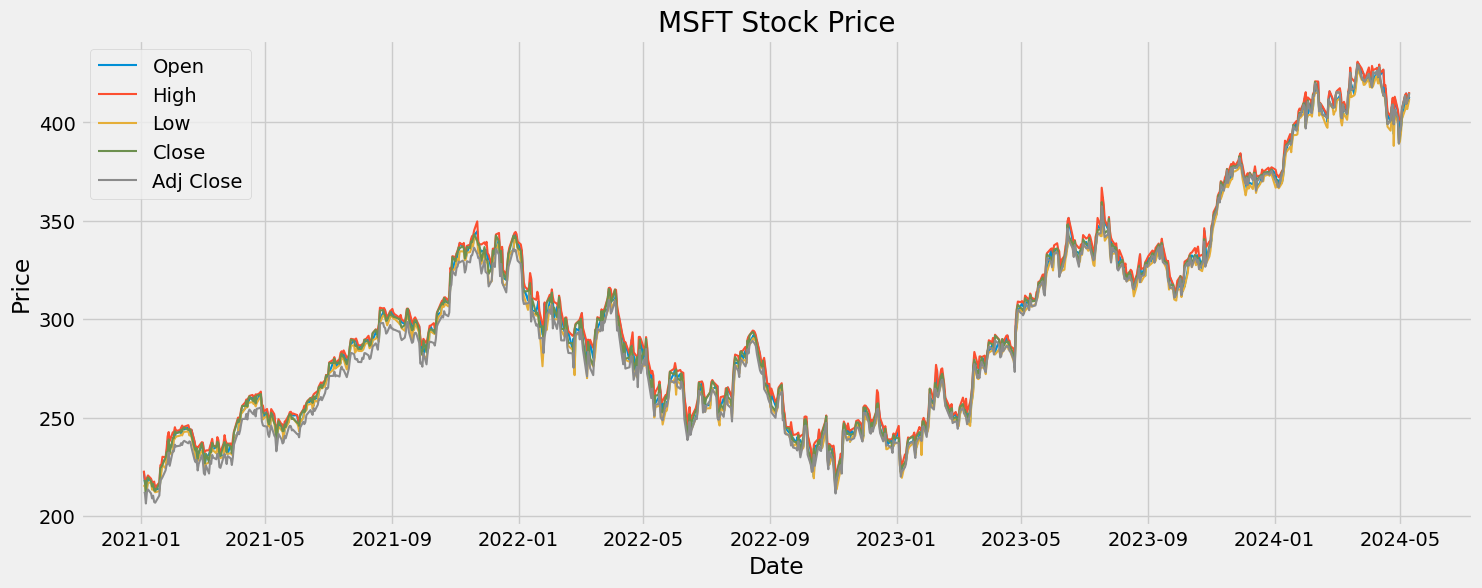

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(df.index, df['Open'], label='Open', linewidth=1.5)
plt.plot(df.index, df['High'], label='High', linewidth=1.5)
plt.plot(df.index, df['Low'], label='Low', linewidth=1.5)
plt.plot(df.index, df['Close'], label='Close', linewidth=1.5)
plt.plot(df.index, df['Adj Close'], label='Adj Close', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MSFT Stock Price')
plt.legend()
plt.show()

The stock price of Microsoft, a significant company, showed substantial volatility. Approximately 30% of the time, the stock price experienced changes greater than 1% daily. Sharp spikes in price change were observed around early 2022 and throughout 2023 due to market uncertainty caused by the changes in monetary policies, geopolitical tensions, trade agreements and international disputes.

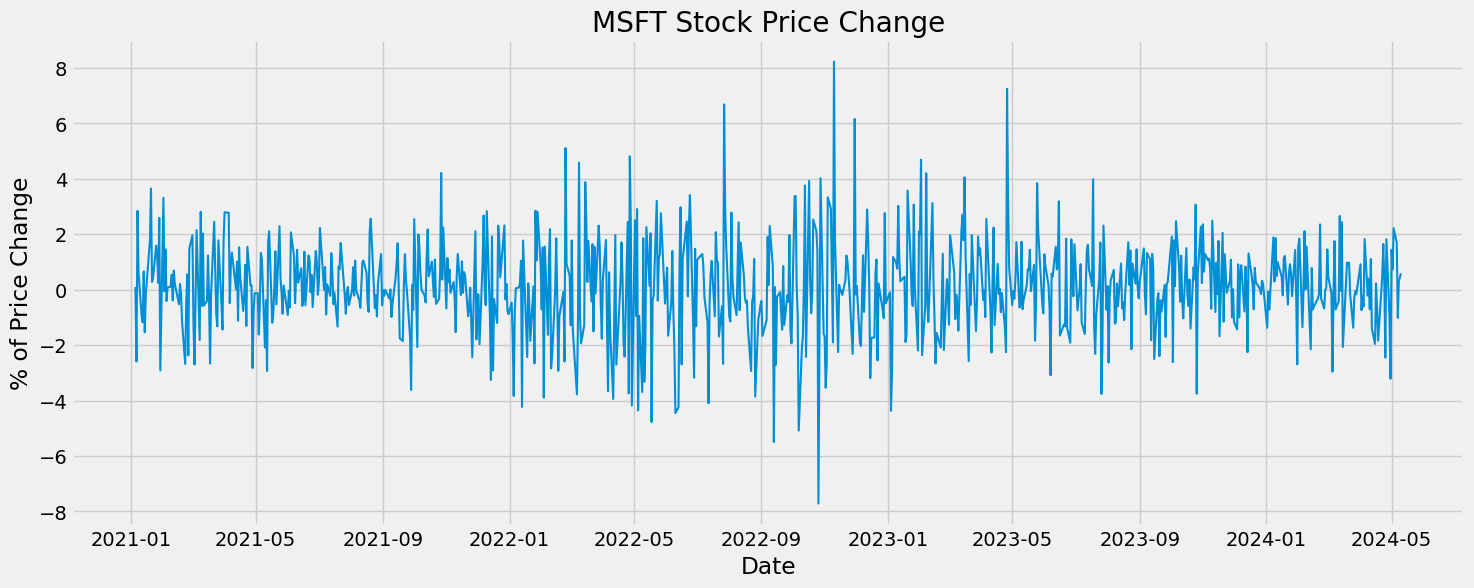

In [ ]:
plt.figure(figsize=(16,6))
df['Change'] = (df.Close.div(df.Close.shift()) - 1) * 100
plt.plot(df.index, df['Change'], label='% of Price Change to Last Price', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel( '% of Price Change')
plt.title('MSFT Stock Price Change')

plt.show()



In [ ]:
round(sum(df['Change'] > 1)/len(df['Change']),2)

0.28

The ACF shows a gradual decline but a sharp cut-off, indicating non-stationarity in the stock prices, which was consistent with the observed high volatility. Thus, we should considered this non-stationarity before model fitting.

The PACF plot shows a significant spike at the first lag and essentially no correlation for higher lags. This suggested that the series may be a first-order autoregressive process (AR(1)).



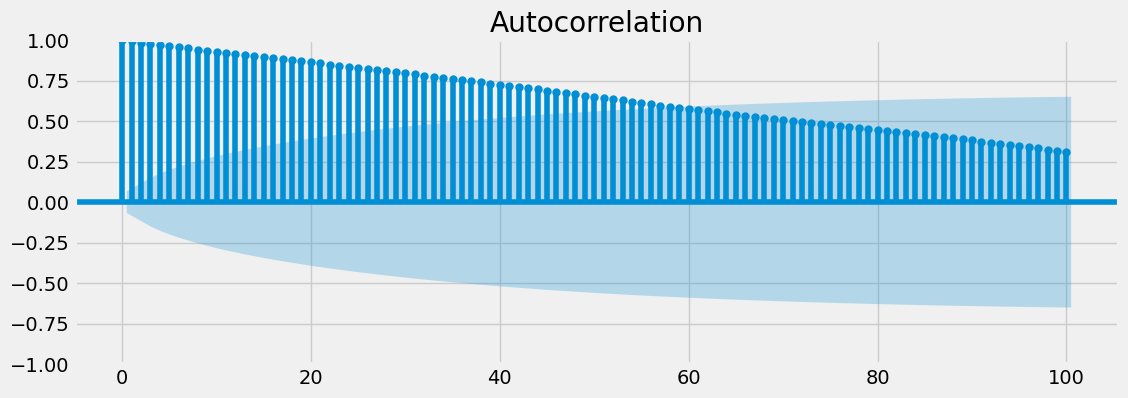

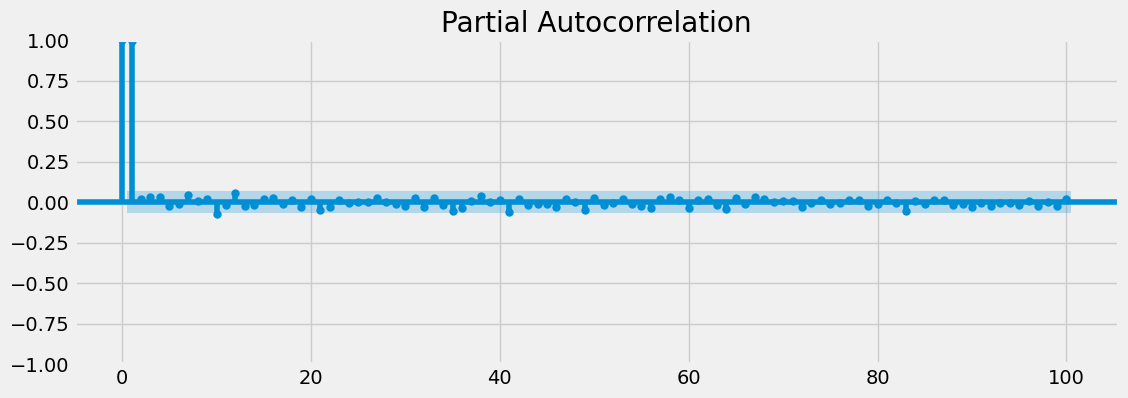

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
plot_acf(df['Close'], lags=100)
plt.show()
plot_pacf(df['Close'], lags=100)
plt.show()

#Part 2: Modeling

## 2.1 ARIMA

If we did log transformation and differenced once, the stock price would be stationary. From the ACF and PACF graph,This we chose ARIMA(3,1,3) to fit the stock price.

In [ ]:
df['Log_Close'] = np.log(df['Close'])
diff = df['Log_Close']- df['Log_Close'].shift()

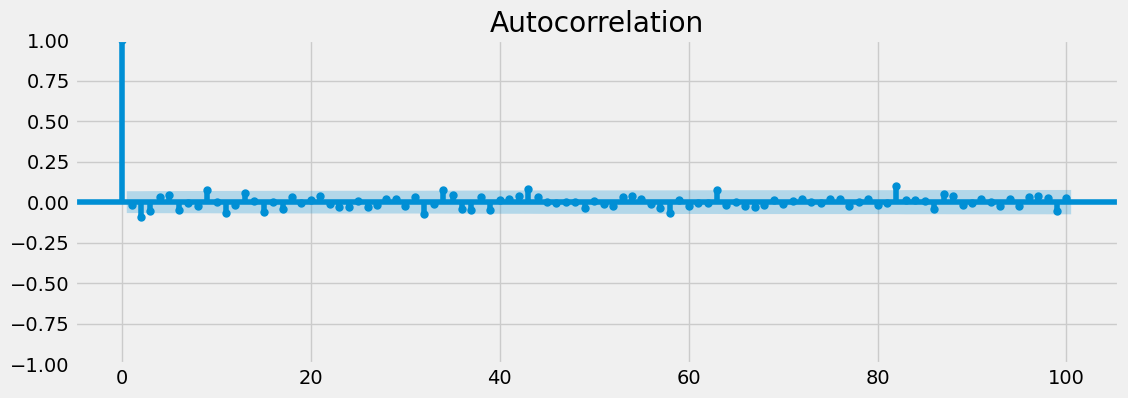

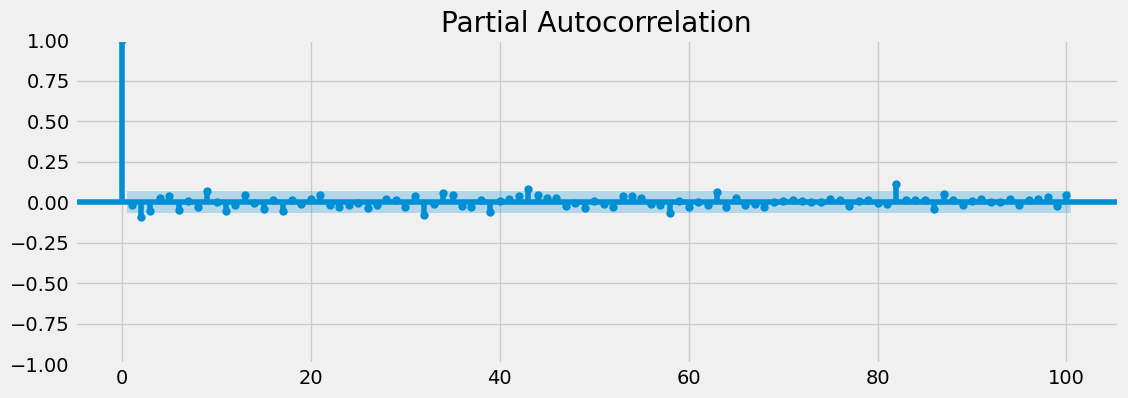

In [ ]:
rcParams['figure.figsize'] = 12, 4
plot_acf(diff[1:], lags=100)
plt.show()
plot_pacf(diff[1:], lags=100)
plt.show()

The diagnostics suggest that the model performed well. The residuals appeared to be random (though lttile higher between 300 - 500), mostly normal with little tails, and centered around zero.

The model achieved very high accuracy in predicting the stock price for the next day and mid long term (30 - 60 days), with error rates of 1% and 2% respectively. However, the model accuracy decreased as we predict longer stock price. The error rate of stock price >= 90 days increased to 11%.

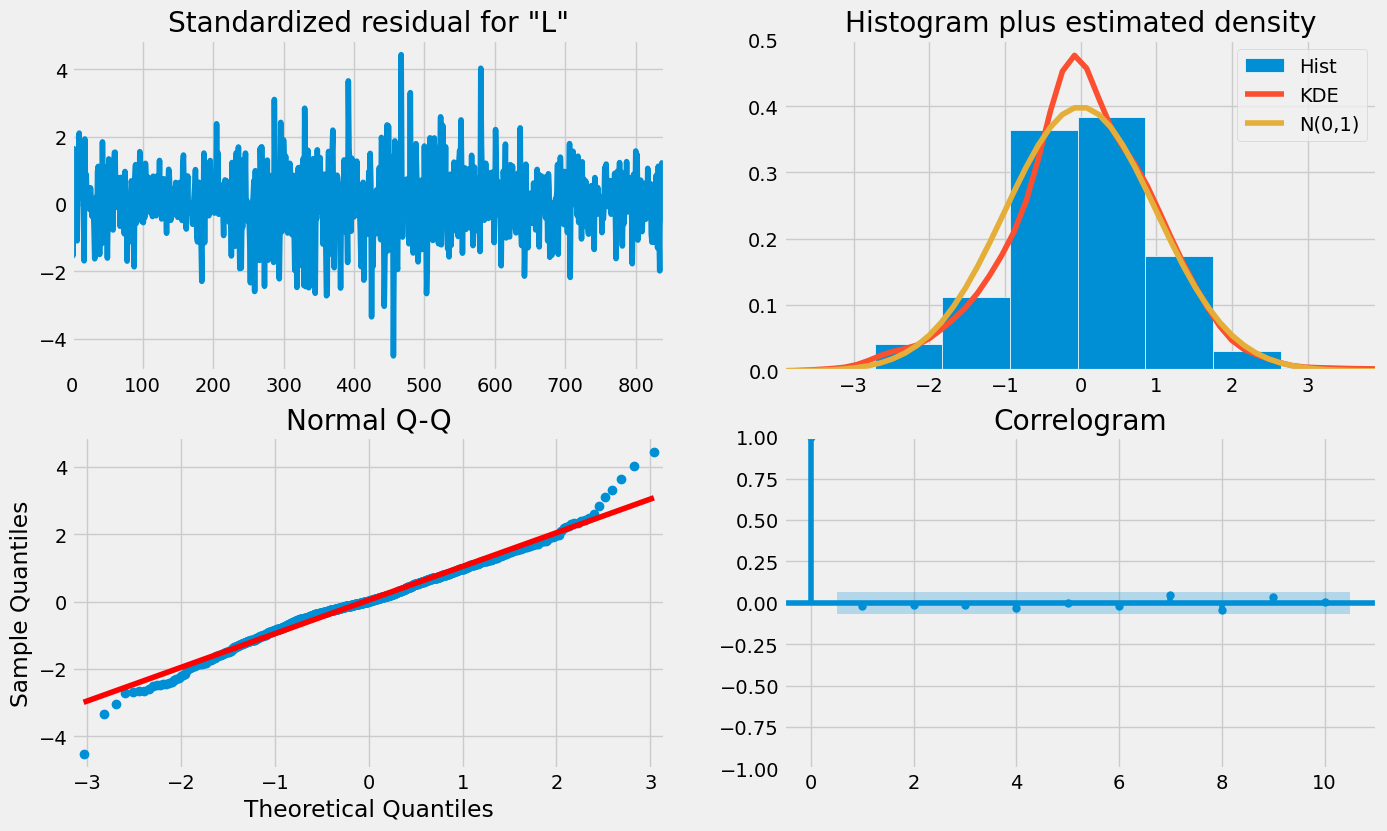

In [ ]:
#model fitting
mod = sm.tsa.statespace.SARIMAX(df['Log_Close'] ,order=(3, 1, 3))

MSFTresults = mod.fit()

MSFTresults.plot_diagnostics(figsize=(15, 9))
plt.show()

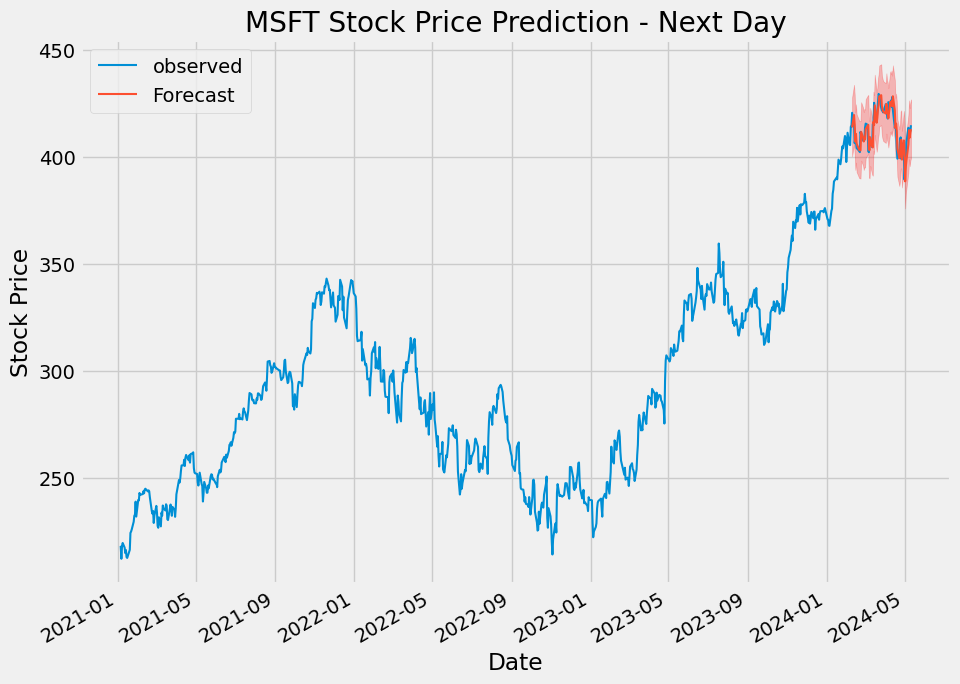

In [ ]:
#next day prediction
pred = MSFTresults.get_prediction(start=df.index[780], dynamic=False, full_results=False)
pred_ci = pred.conf_int()


ax = df.Close.plot(label='observed', figsize=(10, 8), linewidth=1.5)
np.exp(pred.predicted_mean).plot(label='Forecast', ax=ax ,linewidth=1.5)
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='r', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title('MSFT Stock Price Prediction - Next Day')
plt.legend()
plt.show()



In [ ]:
#error rate for next day prediction
round(np.mean(abs(df.Close[780:] - np.exp(pred.predicted_mean))/df.Close[780:]),3)


0.01

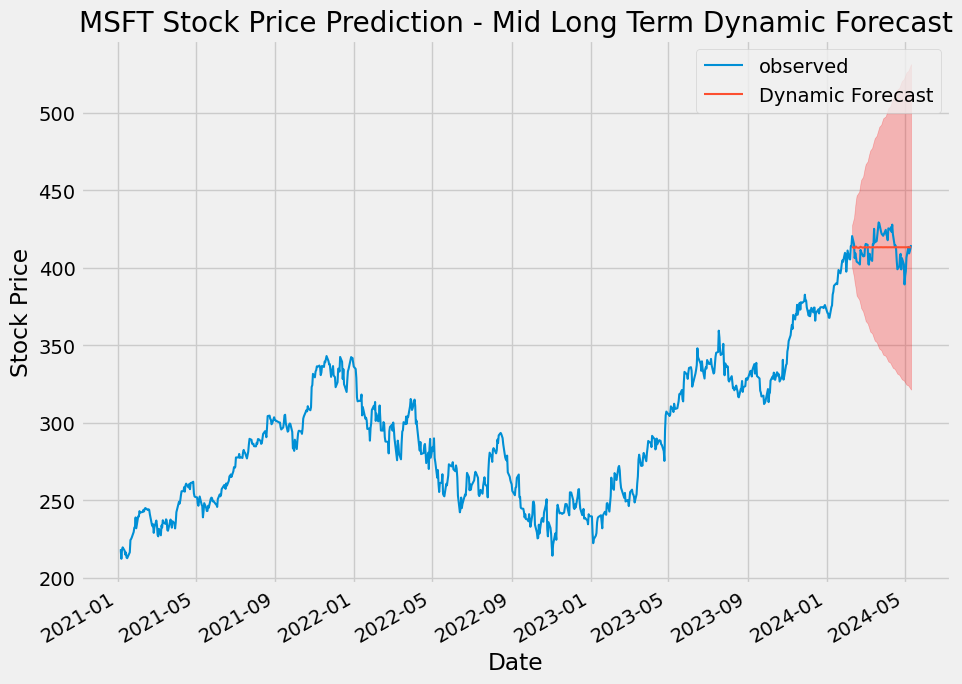

In [ ]:
#mid long term prediction
pred_dynamic = MSFTresults.get_prediction(start=df.index[780], dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


ax = df.Close.plot(label='observed', figsize=(10, 8), linewidth=1.5)
np.exp(pred_dynamic.predicted_mean).plot(label='Dynamic Forecast', ax=ax ,linewidth=1.5)
ax.fill_between(pred_dynamic_ci.index,
                np.exp(pred_dynamic_ci.iloc[:, 0]),
                np.exp(pred_dynamic_ci.iloc[:, 1]), color='r', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title('MSFT Stock Price Prediction - Mid Long Term Dynamic Forecast')
plt.legend()
plt.show()

In [ ]:
round(np.mean(abs(df.Close[810:] - np.exp(pred_dynamic.predicted_mean[30:]))/df.Close[810:]),3)

0.021

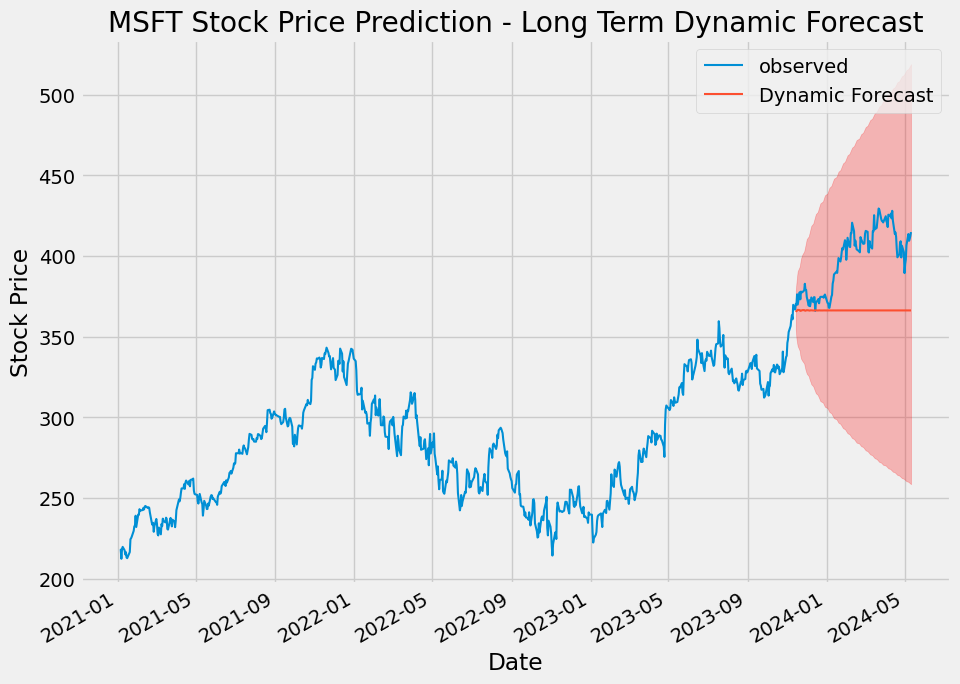

In [ ]:
#long term prediction
pred_dynamic = MSFTresults.get_prediction(start=df.index[721], dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


ax = df.Close.plot(label='observed', figsize=(10, 8), linewidth=1.5)
np.exp(pred_dynamic.predicted_mean).plot(label='Dynamic Forecast', ax=ax ,linewidth=1.5)
ax.fill_between(pred_dynamic_ci.index,
                np.exp(pred_dynamic_ci.iloc[:, 0]),
                np.exp(pred_dynamic_ci.iloc[:, 1]), color='r', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title('MSFT Stock Price Prediction - Long Term Dynamic Forecast')
plt.legend()
plt.show()

In [ ]:
round(np.mean(abs(df.Close[810:] - np.exp(pred_dynamic.predicted_mean[90:]))/df.Close[810:]),3)

0.112

##2.2 GAM

In this session, we used the GAM model to assess if forecasting the stock price based on long-term trends and seasonality would improve accuracy for long-term predictions.

GAM model preformed similarly as ARIMA model. It achieved very high accuracy in predicting the stock price for the next day and mid long term (30 - 60 days), with error rates of <1% and 3.5% respectively. However, the model accuracy decreased as we predict longer stock price. The error rate of stock price >= 90 days increased to 14%.

In [ ]:
# train test split
train = df[:721]
test = df[721:]

In [ ]:
from prophet import Prophet
from prophet.plot import plot_components
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from prophet.plot import add_changepoints_to_plot

# Fit the model
m = Prophet(weekly_seasonality=False)
train = train.reset_index().rename(columns={'Date': 'ds', 'Log_Close': 'y'})
m.fit(train)

# Generate future data points
future = m.make_future_dataframe(periods=len(test), freq='d')

# Forecast the future data points
forecast = m.predict(future)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeq9dhf7e/r_w0wy19.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeq9dhf7e/g4p1hs0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84136', 'data', 'file=/tmp/tmpeq9dhf7e/r_w0wy19.json', 'init=/tmp/tmpeq9dhf7e/g4p1hs0z.json', 'output', 'file=/tmp/tmpeq9dhf7e/prophet_model5s_3y4yo/prophet_model-20240525063850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:38:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:38:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
price = test.Close.reset_index(drop=True)
price_pred = np.exp(forecast.yhat[721:].reset_index(drop=True))

In [ ]:
#next day prediction
round(abs(price[0] - price_pred[0])/price[0],3)

0.005

In [ ]:
#30 to 60 days prediction
round(np.mean(abs(price[31:61] - price_pred[31:61])/price[31:61]),3)

0.037

In [ ]:
# >90 days price
round(np.mean(abs(price[91:] - price_pred[91:])/price[91:]),3)

0.147

The trend shows a general upward trajectory, with a decrease in 2022 and steady recovery since early 2023, likely due to the Federal Reserve's interest rate hike in early 2022 and the rise of AI in early 2023.


Seasonal patterns indicated a price decrease from July, likely due to reduced liquidity as investors take vacations, and a recovery in October as market sentiment improves with increased economic activity and positive outlooks for the next fiscal year.

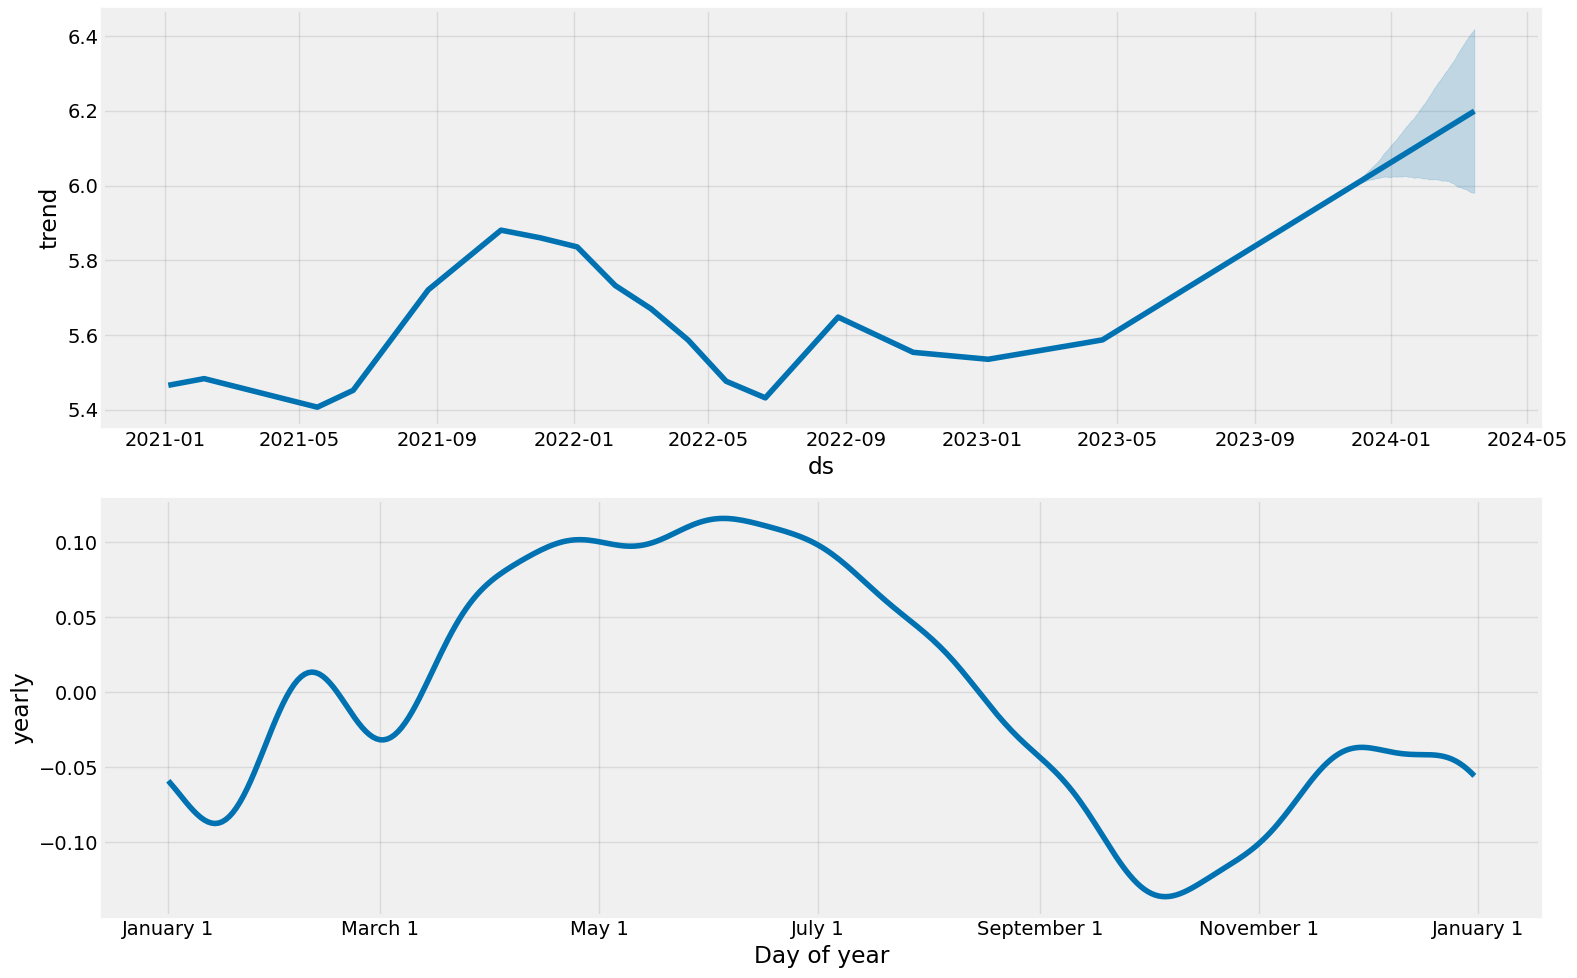

In [ ]:
# prompt: fig = plot_components(m, forecast, figsize=(16, 10)) add titile

fig = plot_components(m, forecast, figsize=(16, 10))

## LTSM

In this session, we tried  LTMS model to assess if forecasting the stock price based on more complicated Machine Learning model.

LTSM model preformed worse than both ARIMA and GAM model. It also achieved very high accuracy in predicting the stock price for the next day and mid long term (30 - 60 days), but the model accuracy decreased as we predict longer stock price. The error rate of stock price >= 90 days increased to 25%.

Epoch 1/10
23/23 [==============================] - 9s 9ms/step - loss: 0.2119
Epoch 2/10
23/23 [==============================] - 0s 9ms/step - loss: 0.0933
Epoch 3/10
23/23 [==============================] - 0s 9ms/step - loss: 0.0380
Epoch 4/10
23/23 [==============================] - 0s 9ms/step - loss: 0.0260
Epoch 5/10
23/23 [==============================] - 0s 10ms/step - loss: 0.0136
Epoch 6/10
23/23 [==============================] - 0s 10ms/step - loss: 0.0078
Epoch 7/10
23/23 [==============================] - 0s 15ms/step - loss: 0.0071
Epoch 8/10
23/23 [==============================] - 0s 15ms/step - loss: 0.0063
Epoch 9/10
23/23 [==============================] - 0s 17ms/step - loss: 0.0059
Epoch 10/10
4/4 [==============================] - 5s 7ms/step


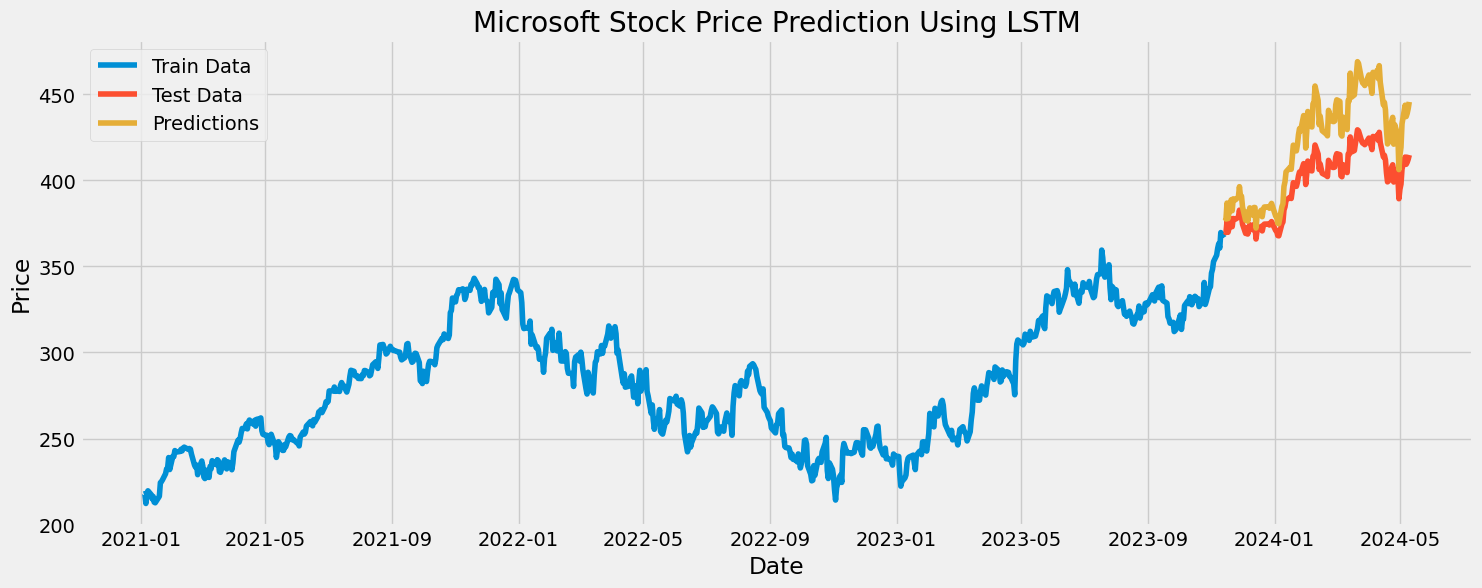

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Assuming df is already loaded and preprocessed
df_ltsm = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_ltsm['ds'] = pd.to_datetime(df_ltsm['ds'])  # Ensure 'ds' is datetime

train_df = df_ltsm[:721].set_index('ds')
test_df = df_ltsm[721:].set_index('ds')

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_df['y'].values.reshape(-1, 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_data, train_data, epochs=10, batch_size=32)

test_data = scaler.transform(test_df['y'].values.reshape(-1, 1))
predictions = model.predict(test_data)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(16, 6))
plt.plot(train_df.index, train_df['y'], label='Train Data')
plt.plot(test_df.index, test_df['y'], label='Test Data')
plt.plot(test_df.index, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Microsoft Stock Price Prediction Using LSTM')
plt.legend()
plt.show()


In [ ]:
#next day prediction
price = test_df['y'].reset_index(drop=True)
pred_price = pd.DataFrame(predictions).reset_index(drop=True)
round(abs(price[0] - pred_price.iloc[0])/price[0],3)

0    0.022
Name: 0, dtype: float32

In [ ]:
# 30 to 60 days prediction
round(sum(abs(price[30:61] - pred_price.iloc[30:61]))/sum(price[0:61]),3)

0.06

In [ ]:
# > 90 days prediction
round(sum(abs(price[91:] - pred_price.iloc[91:]))/sum(price[91:]),3)

0.258

# Part 3 : Summary


This project primarily focused on predicting the stock prices with time series model. All of the 3 models(ARIMA, GAM and LSTM) provided highly accurate short-term and mid-term forecasts for MSFT stock prices. However, their performance diminished over longer forecasting horizons, with the error rates increasing significantly for predictions extending to 90 days or beyond. This indicated the inherent challenges in predicting stock prices over extended periods due to market volatility and unforeseen factors since as the changes of Federal interest policy and the prospertiy for AI.